In [2]:
# import libaries
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns



import os
from dotenv import load_dotenv

In [4]:
#functions to get tracks from spotify

def get_access_token(id: str, secret: str):
    token_url = 'https://accounts.spotify.com/api/token'
    credentials = f'{id}:{secret}'
    encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')

    headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-type': 'application/x-www-form-urlencoded',
    }

    data = {
        'grant_type': 'client_credentials'
    }

    print("getting access token from spotify")
    response = requests.post(token_url, headers=headers, data=data)
    if response.status_code == 200:

        print("fetched token successfully, token:",response.json()['access_token'])

        return response.json()['access_token']

    else:
        raise Exception('Failed to retrieve access token')

def get_playlist_tracks(playlist_id, token):
    all_tracks = []
    limit = 100
    offset = 0
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    print("getting playlists from spotify")
    while True:
        params = {
            'limit': limit,
            'offset': offset,
        }
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            print("fetched playlists from spotify succesfully")
            data = response.json()
            all_tracks.extend([item['track'] for item in data['items']])

            if len(data['items']) < limit:
                break
            else:
                offset += limit
        else:
            raise Exception(f"Failed to retrieve tracks: {response.status_code}")
    return all_tracks




def get_audio_features_for_tracks(playlists_ids, token):
    url = f'https://api.spotify.com/v1/audio-features'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    params = {
        'ids': ','.join(playlists_ids)
    }

    print("getting audio features from spotify")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched audio features from spotify")
        return response.json()['audio_features']
    else:
        raise Exception(f"Failed to retrieve audio features: {response.status_code}")


def get_playlist_audio_features(playlists, token):

    audio_features = []
    for i in range(0, len(playlists), 100):
        batch_track_ids = [playlist["id"] for playlist in playlists[i:i+100]]
        features = get_audio_features_for_tracks(batch_track_ids, token)
        audio_features.extend(features)

    return audio_features



In [5]:
# the function to get recommendations based on some tracks, target audio features (if any)
# this will be used to benchmark results

def get_recommendations(seed_tracks, target_audio_features, token):
    url = 'https://api.spotify.com/v1/recommendations'
    headers = {
        "Authorization": f'Bearer {token}'
    }

    params = {
        'seed_tracks': ','.join(seed_tracks),
        'limit': 10,
    }

    if target_audio_features['danceability'] != None:
        params['target_danceability'] = target_audio_features['danceability']
    if target_audio_features['energy'] != None:
        params['target_energy'] = target_audio_features['energy']
    if target_audio_features['valence'] != None:
        params['target_valence'] = target_audio_features['valence']
    if target_audio_features['tempo'] != None:
        params['target_tempo'] = target_audio_features['tempo']
    if target_audio_features['loudness'] != None:
        params['target_loudness'] = target_audio_features['loudness']
    if target_audio_features['speechiness'] != None:
        params['target_speechiness'] = target_audio_features['speechiness']
    if target_audio_features['acousticness'] != None:
        params['target_acousticness'] = target_audio_features['acousticness']
    if target_audio_features['instrumentalness'] != None:
        params['target_instrumentalness'] = target_audio_features['instrumentalness']
    if target_audio_features['liveness'] != None:
        params['target_liveness'] = target_audio_features['liveness']

    print("getting recommendations from spotify API")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched recommendations successfully")
        return response.json()['tracks']
    else:
        raise Exception(f"failed to get recommendations: {response.status_code}")

In [6]:
# functions to manipulate dataset

def preprocess_features(audio_features_df):
    #scale the the selected audio features so they have a mean of 0 and sd of 1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(audio_features_df)
    
    return pd.DataFrame(X_scaled, columns=audio_features_df.columns)

def extract_artists_name(artists):
    return ', '.join([artist['name'] for artist in artists])
    # return artists[0]['name'] ### works if there is only 1 artist

In [ ]:
# get id and secret from .env file, then request token from spotify api
load_dotenv()
id = os.getenv('API_ID')
secret = os.getenv('API_SECRET')
print(id)
print(secret)


token = get_access_token(id, secret)

In [7]:
#import dataset and show some rows of dataset
dataset = pd.read_csv("dataset.csv")

dataset.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [8]:
#columns of dataset
print(dataset.size, dataset.shape)
dataset.columns

2394000 (114000, 21)


Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [9]:
#list of unique track genre in the dataset
print(dataset['track_genre'].unique().size)
dataset['track_genre'].unique()

114


array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [10]:
#map similar genres to the same genre, so that the model gives better accuracy
#electronic has a lot, and it seems that many songs are predicted as electronic

genre_mapping = {
    'pop': ['pop', 'indie-pop', 'pop-film', 'power-pop', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'k-pop', 'anime', 'cantopop', 'mandopop', 'synth-pop'],
    'rock': ['goth', 'emo', 'rock', 'alt-rock', 'hard-rock', 'punk-rock', 'punk', 'rock-n-roll', 'grunge', 'psych-rock', 'alternative', 'rockabilly'],
    'hip-hop': ['hip-hop', 'rap', 'trap', 'trip-hop', 'disco', 'funk'],
    'electronic': ['party', 'dance', 'edm', 'electronic', 'techno', 'trance', 'house', 'deep-house', 'club', 'electro', 'progressive-house', 'idm', 'drum-and-bass', 'breakbeat', 'garage', 'minimal-techno', 'detroit-techno', 'chicago-house'],
    'jazz_blues': ['jazz', 'blues', 'soul', 'gospel'],
    'classical': ['classical', 'opera', 'piano'],
    'metal': ['heavy-metal', 'black-metal', 'death-metal', 'metalcore', 'grindcore', 'hardcore', 'hardstyle'],
    'country': ['country', 'honky-tonk'],
    'folk': ['folk', 'bluegrass', 'singer-songwriter', 'guitar', 'tango'],
    'latin': ['latin', 'latino', 'salsa', 'samba', 'forro', 'pagode', 'mpb', 'sertanejo'],
    'world_music': ['world-music', 'afrobeat', 'turkish', 'indian', 'swedish', 'iranian', 'malay', 'french', 'german', 'brazil', 'british', 'spanish'],
    'reggae_dub': ['reggae', 'reggaeton' 'dub', 'dubstep', 'dancehall', 'ska'],
    'rnb_soul': ['r-n-b', 'soul', 'groove'],
    'ambient_new_age': ['ambient', 'new-age', 'chill', 'study', 'sleep', 'acoustic'],
    'soundtracks_theme': ['disney', 'show-tunes', 'comedy', 'children', 'kids', 'happy', 'indie', 'industrial'],
    'romance': ['romance', 'sad'],
}

genre_reverse_mapping = {subgenre: main_genre for main_genre, subgenres in genre_mapping.items() for subgenre in subgenres}

# map each genre in the dataset to the new genre, if new genre does not exist (genre not in the list above), it will be None
dataset['main_genre'] = dataset['track_genre'].map(genre_reverse_mapping)

# drop all None values 
dataset = dataset.dropna(subset=['main_genre'])

print(dataset.size, dataset.shape)
print(dataset.columns)
print(dataset[['track_genre', 'main_genre']].head())
print(dataset['main_genre'].unique())

2420000 (110000, 22)
Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'main_genre'],
      dtype='object')
  track_genre       main_genre
0    acoustic  ambient_new_age
1    acoustic  ambient_new_age
2    acoustic  ambient_new_age
3    acoustic  ambient_new_age
4    acoustic  ambient_new_age
['ambient_new_age' 'world_music' 'rock' 'pop' 'metal' 'folk' 'jazz_blues'
 'electronic' 'soundtracks_theme' 'classical' 'country' 'reggae_dub'
 'hip-hop' 'latin' 'rnb_soul' 'romance']


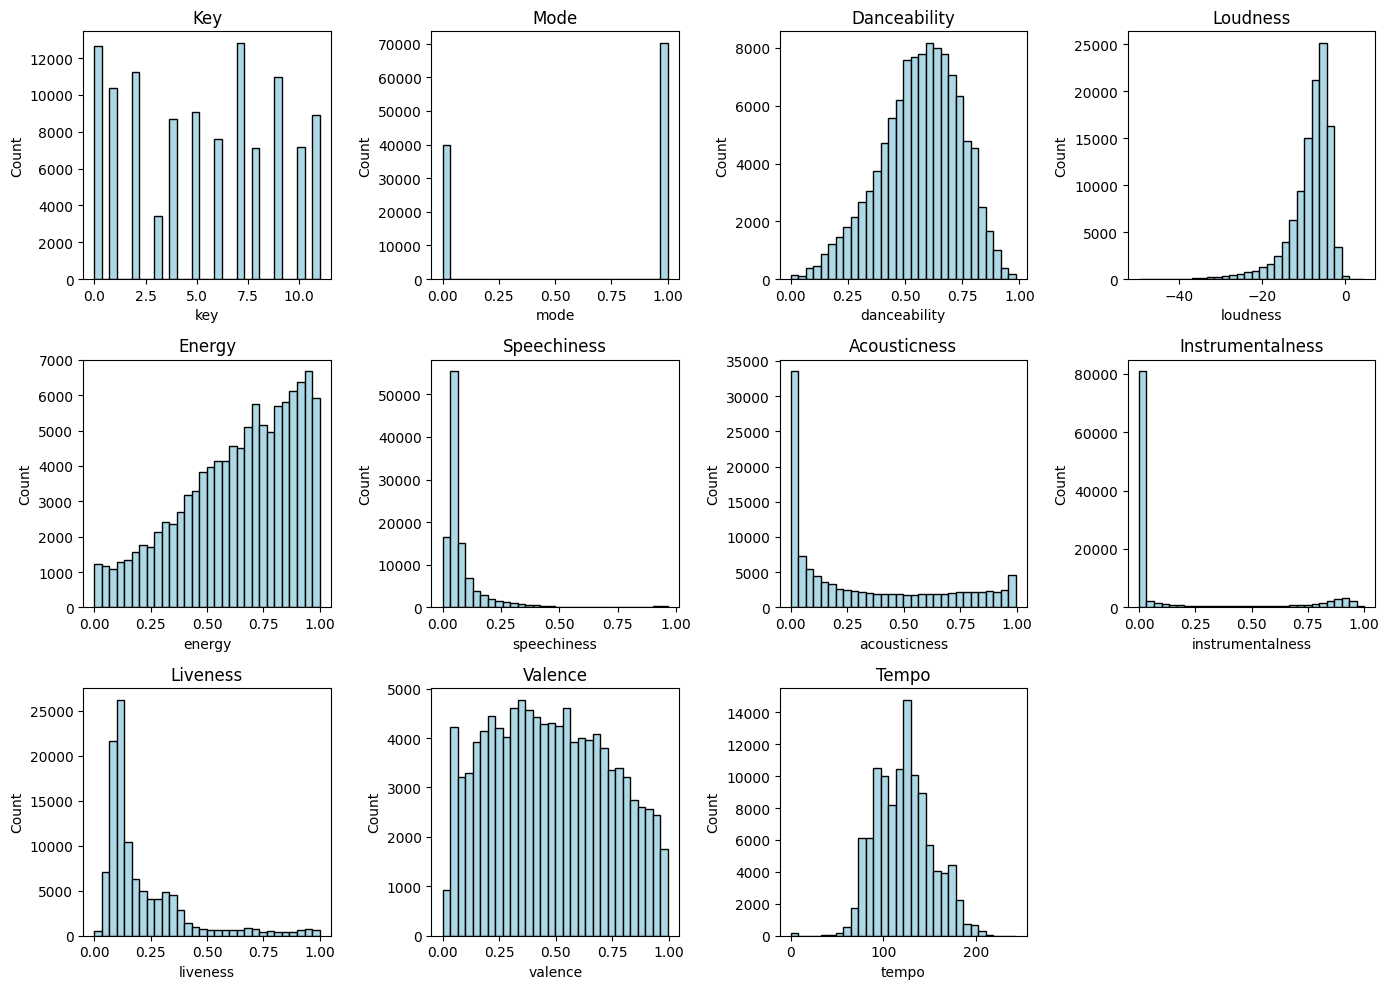

In [30]:
#plot the histogram of features
audio_features = ['key', 'mode', 'danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(14,10))
for i, feature in enumerate(audio_features):
    plt.subplot(3, 4, i + 1)
    plt.hist(dataset[feature], bins= 30, color='lightblue', edgecolor='black')
    plt.title(f'{feature.capitalize()}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [37]:
#extract the key features from the dataset, then split into train and test datasets (using 'track_genre' as the label)

#encode the artist name
label_encoder = LabelEncoder()
dataset['artists_encoded'] = label_encoder.fit_transform(dataset['artists'])
features_df = dataset[['key', 'mode', 'danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'artists_encoded']]
features_df = preprocess_features(features_df)
print(dataset['artists_encoded'].unique().size)

# # Apply PCA for Dimensionality Reduction
# pca = PCA(n_components=3)  # Keep top 3 components
# X_reduced = pca.fit_transform(features_df)

X_train, X_test, y_train, y_test = train_test_split(features_df, dataset['main_genre'], test_size=0.2, random_state=42)
X_train

31268


,key,mode,danceability,loudness,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artists_encoded
72236,-0.928730,0.753629,0.955272,-0.472900,-0.023394,-0.460390,-0.621374,-0.511278,-0.207486,1.583293,-1.206981,-0.908681
32086,-0.366834,0.753629,-0.592310,1.037168,0.859977,-0.201277,-0.802344,-0.511278,-0.160586,1.467897,-0.348801,0.382878
45550,0.756958,0.753629,-0.500260,1.336617,1.267992,-0.363692,-0.917098,-0.510961,-0.108474,-0.363043,1.767549,0.870075
104659,-0.928730,-1.326913,-0.459989,0.023617,-0.859230,-0.503575,1.802541,0.098857,-0.755179,0.525502,0.848292,1.071525
5660,0.476010,0.753629,-0.592310,0.976015,1.311566,0.482179,-0.949756,-0.511278,0.475175,-0.101480,-1.037859,-0.619615
...,...,...,...,...,...,...,...,...,...,...,...,...
54886,1.599802,-1.326913,0.132580,-0.587512,-0.827540,-0.544883,1.451988,-0.388931,-0.561845,-0.966946,-0.206021,0.673382
76820,-1.209678,-1.326913,1.381001,0.158941,0.352930,-0.439736,-0.908409,-0.511278,-0.697335,1.925633,-0.003235,-1.104710
103694,-1.209678,0.753629,0.811445,-0.137154,-0.261073,-0.565537,0.819792,-0.511161,-0.792178,0.856302,-0.870709,0.793964
860,0.195062,0.753629,-0.833940,-1.355269,-2.111003,-0.480105,1.886435,-0.511278,-0.660336,-1.370830,-0.597152,1.276957


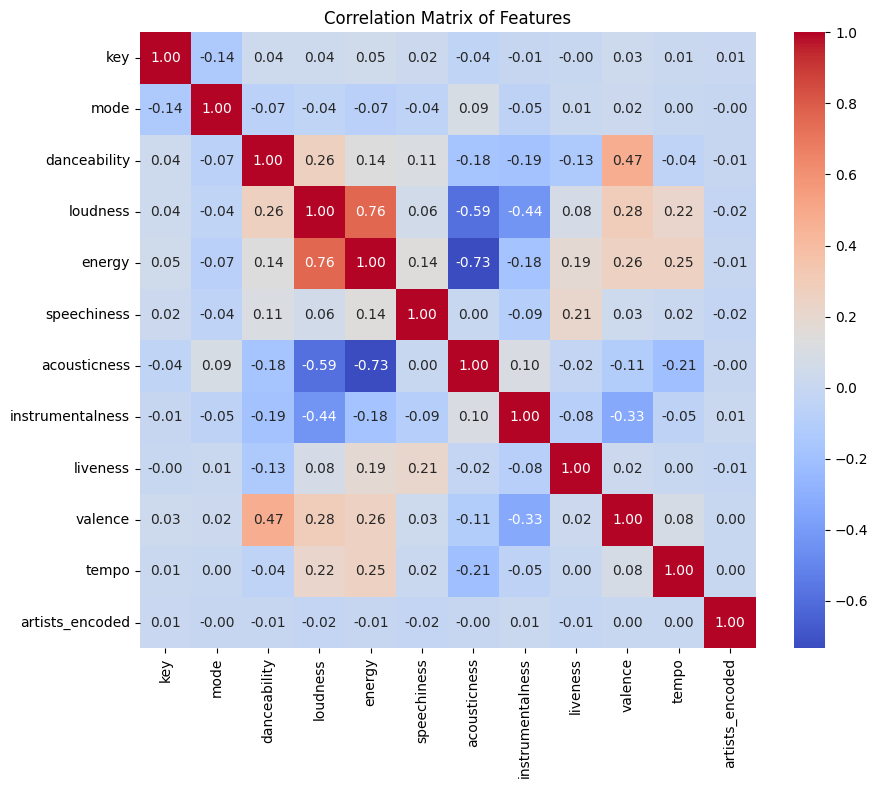

In [39]:
# Correlation matrix
correlation_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


In [ ]:
# Apply t-SNE on the PCA-reduced data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features_df)

# Plot the 2D visualization
label_encoder = LabelEncoder()
numerical_genre_labels = label_encoder.fit_transform(dataset['main_genre'])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=numerical_genre_labels)
plt.title('t-SNE Visualization of Audio Genres')
plt.show()

k=  1
accuracy=  0.3058181818181818
k=  2
accuracy=  0.29268181818181815
k=  3
accuracy=  0.2873181818181818
k=  4
accuracy=  0.2892272727272727
k=  5
accuracy=  0.2903181818181818
k=  6
accuracy=  0.29445454545454547
k=  7
accuracy=  0.29513636363636364
k=  8
accuracy=  0.2965
k=  9
accuracy=  0.2953181818181818
k=  10
accuracy=  0.29554545454545456
k=  11
accuracy=  0.2935
k=  12
accuracy=  0.29395454545454547
k=  13
accuracy=  0.2959090909090909
k=  14
accuracy=  0.2929090909090909
k=  15
accuracy=  0.29254545454545455
k=  16
accuracy=  0.29109090909090907
k=  17
accuracy=  0.29163636363636364
k=  18
accuracy=  0.29063636363636364
k=  19
accuracy=  0.2913636363636364
k=  20
accuracy=  0.2919090909090909


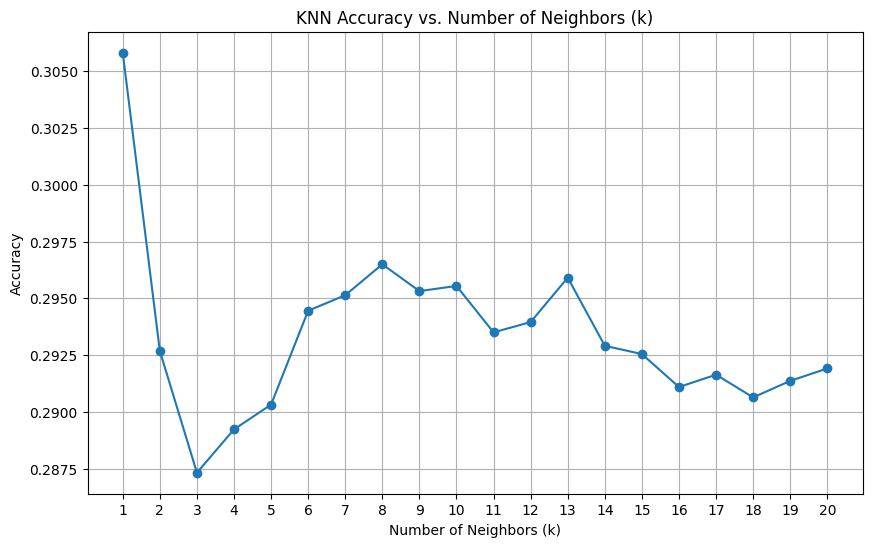

In [55]:
# check the model for the best k to be used in KNN model and plot the graph to visualize
# after finishing, we will use the k with the best accuracy for our model

#range of k values to test
k_values = range(1, 21)  #testing from 1 to 20
accuracies = []
best_k = 1
best_accuracy = 0

for k in k_values:  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    print("k= ", k)
    print("accuracy= ", accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

In [14]:
#training the model using KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

NameError: name 'best_k' is not defined

In [ ]:
#training the model using random forest
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)


In [38]:
#training the model using MLP
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', batch_size=32, max_iter=100, random_state=42)
mlp.fit(X_train, y_train)

c:\Users\gianm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=32, hidden_layer_sizes=(32, 16), max_iter=100,
              random_state=42)

Accuracy: 29.19%
Confusion Matrix:
 [[ 442  102   15  135   94    7   18   31   15  112    3   13   49   20
    25   91]
 [ 150  194    7   41   31    1    8   11    8   43    0    4   29   11
    27   48]
 [  14    8   79   40   60    0   19   21    5   71    2    3   40    2
    11   35]
 [  94   21   14 2040   40   43   15  185  257  351   15    9  327    4
    22  155]
 [ 116   35   41  105  181    7   31   71    6  177    2   11   83   19
    43   87]
 [  20    0    8  240   17   61    4  154   14  114   14   20   73    0
    20   56]
 [  26   11   14   75   49   11  137   38   16  100    3    5   60    5
    13   61]
 [  21    9   16  252   36   28   15  647   21  192   27   13  118    5
    36  118]
 [  10    3    0  327    2    4    0   26  690  119    6    1  169    0
    12   32]
 [  67   23   44  628  120   40   37  227  135  651   17   17  297   14
    53  214]
 [   5    1    4  230    8   21    4  201   51   98   23    3   71    1
    20   54]
 [  21    5    8  127   21   

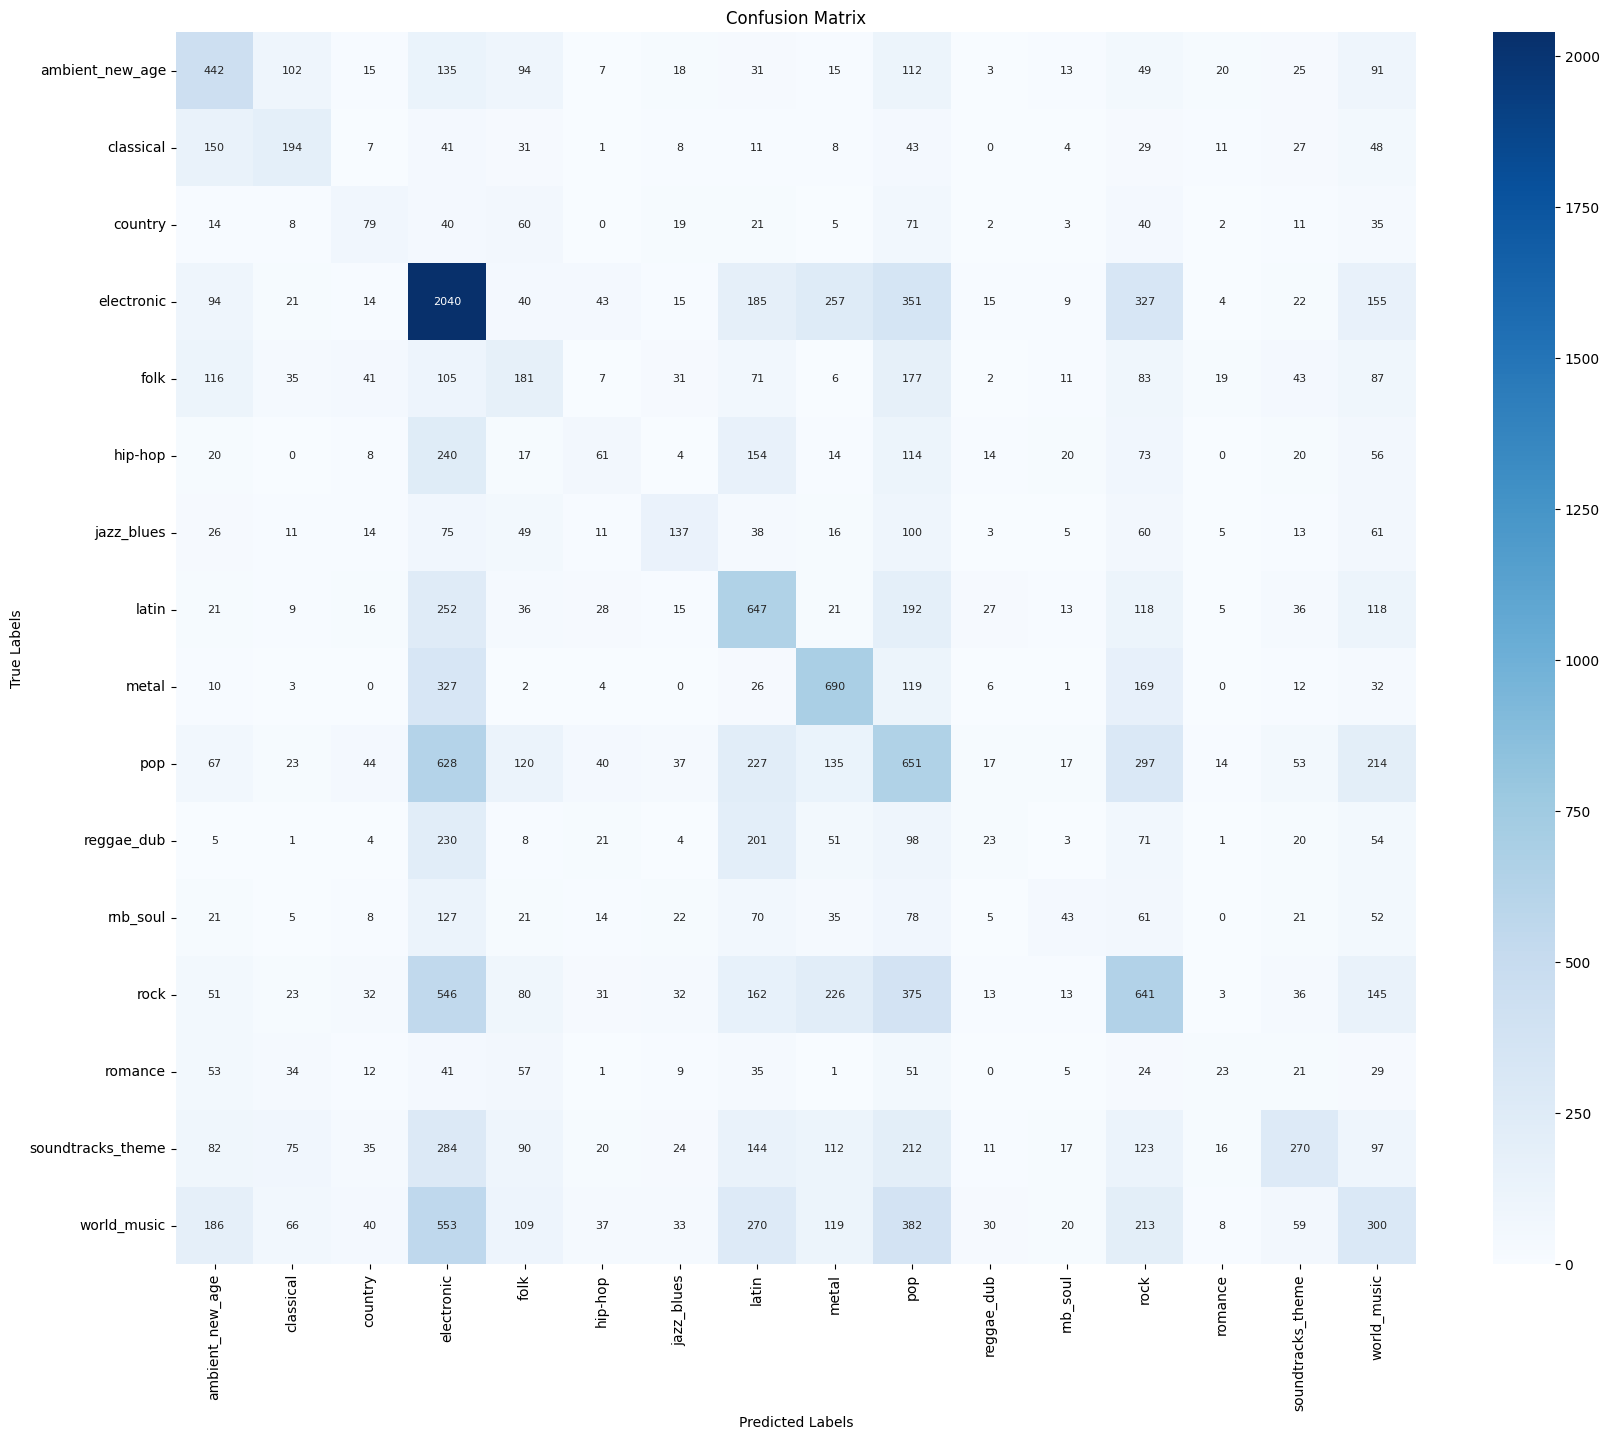

In [57]:
#test the model and check the accuracy for KNN
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 34.99%
Confusion Matrix:
 [[ 388  116   11  122   93    4   14   25   11  117    3   18   42   59
    32  117]
 [ 132  198    3   24   24    2    3   13    8   35    0    0   33    8
    52   78]
 [  13    7  139   17   53    0   10   11    3   49    3    1   37   10
    16   41]
 [  81    8    6 2095   22   69   12  121  222  337   58   48  199   10
    77  227]
 [  96   43   26   70  201    8   12   64    5  160    5    9   84   24
    61  147]
 [  26    0    1  203   10   96    2  114   11  122   21   36   67    1
    30   75]
 [  16   10    2   46   29   10  156   38   12   86    4   16   68    8
    12  111]
 [  10    5    5  125   39   36   13  739   12  157   84   35   80   11
    45  158]
 [   7    2    2  248    4    6    3   20  710  113   24   18  143    0
    55   46]
 [  59   21   17  404   89   78   40  140  110  896   63   10  231   21
   123  282]
 [   7    0    0  147    9   15    2  191   47  125   73    3   66    5
    19   86]
 [  10    3    4   98   16   

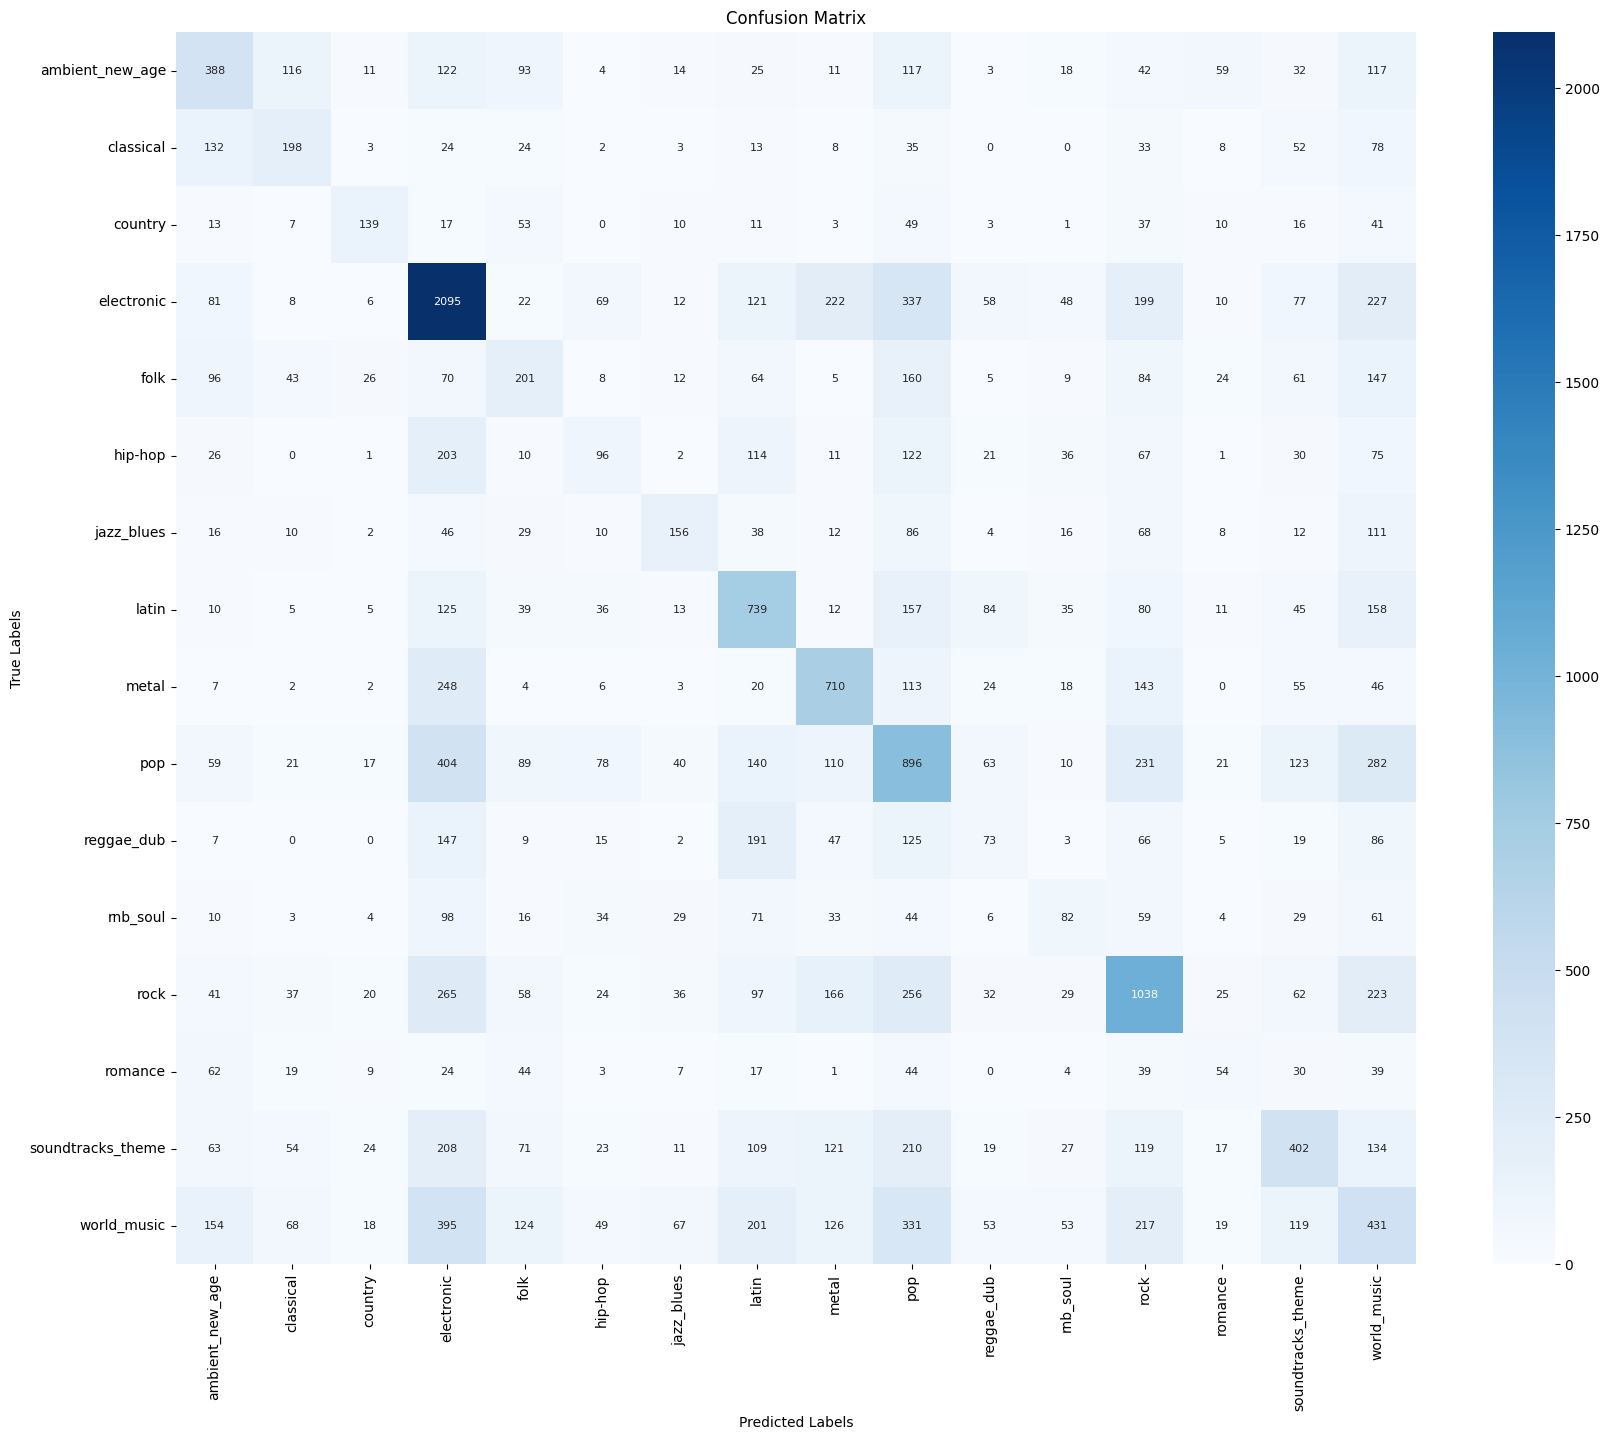

In [58]:
#test the model accuracy for random forest
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 37.07%
Confusion Matrix:
 [[ 582   51   17  104   61    6    5   25    6  103    0    0   61   20
    29  102]
 [ 153  172    7   32   40    0    5   25    4   50    0    1   35   32
    14   43]
 [   2    2   96   34   28    0    5   35    0   91    1    0   85    3
    14   14]
 [  81    3    2 2570   23   20    0  119  125  174   30    1  234   10
    46  154]
 [  97   15   39   49  193    1    6  102    3  234    1    0  126   54
    42   53]
 [  26    0    3  296    3   56    0  111    5   70   28    0   87    4
    29   97]
 [  17   20   31   56   42    3   48   42    4  135    2    0  116   12
    38   58]
 [   6    1    9  154   27   15    2  876    0  200   22    1  113    4
    23  101]
 [   4    0    0  206    0    7    1    9  828   32   15    0  245    0
    17   37]
 [  54    7   31  539   37   29    9  267   89  715   33    1  490   17
    40  226]
 [   2    0    1  215    1   30    0  174   40   70   37    0  104    2
    22   97]
 [   5    1    7  137    4   

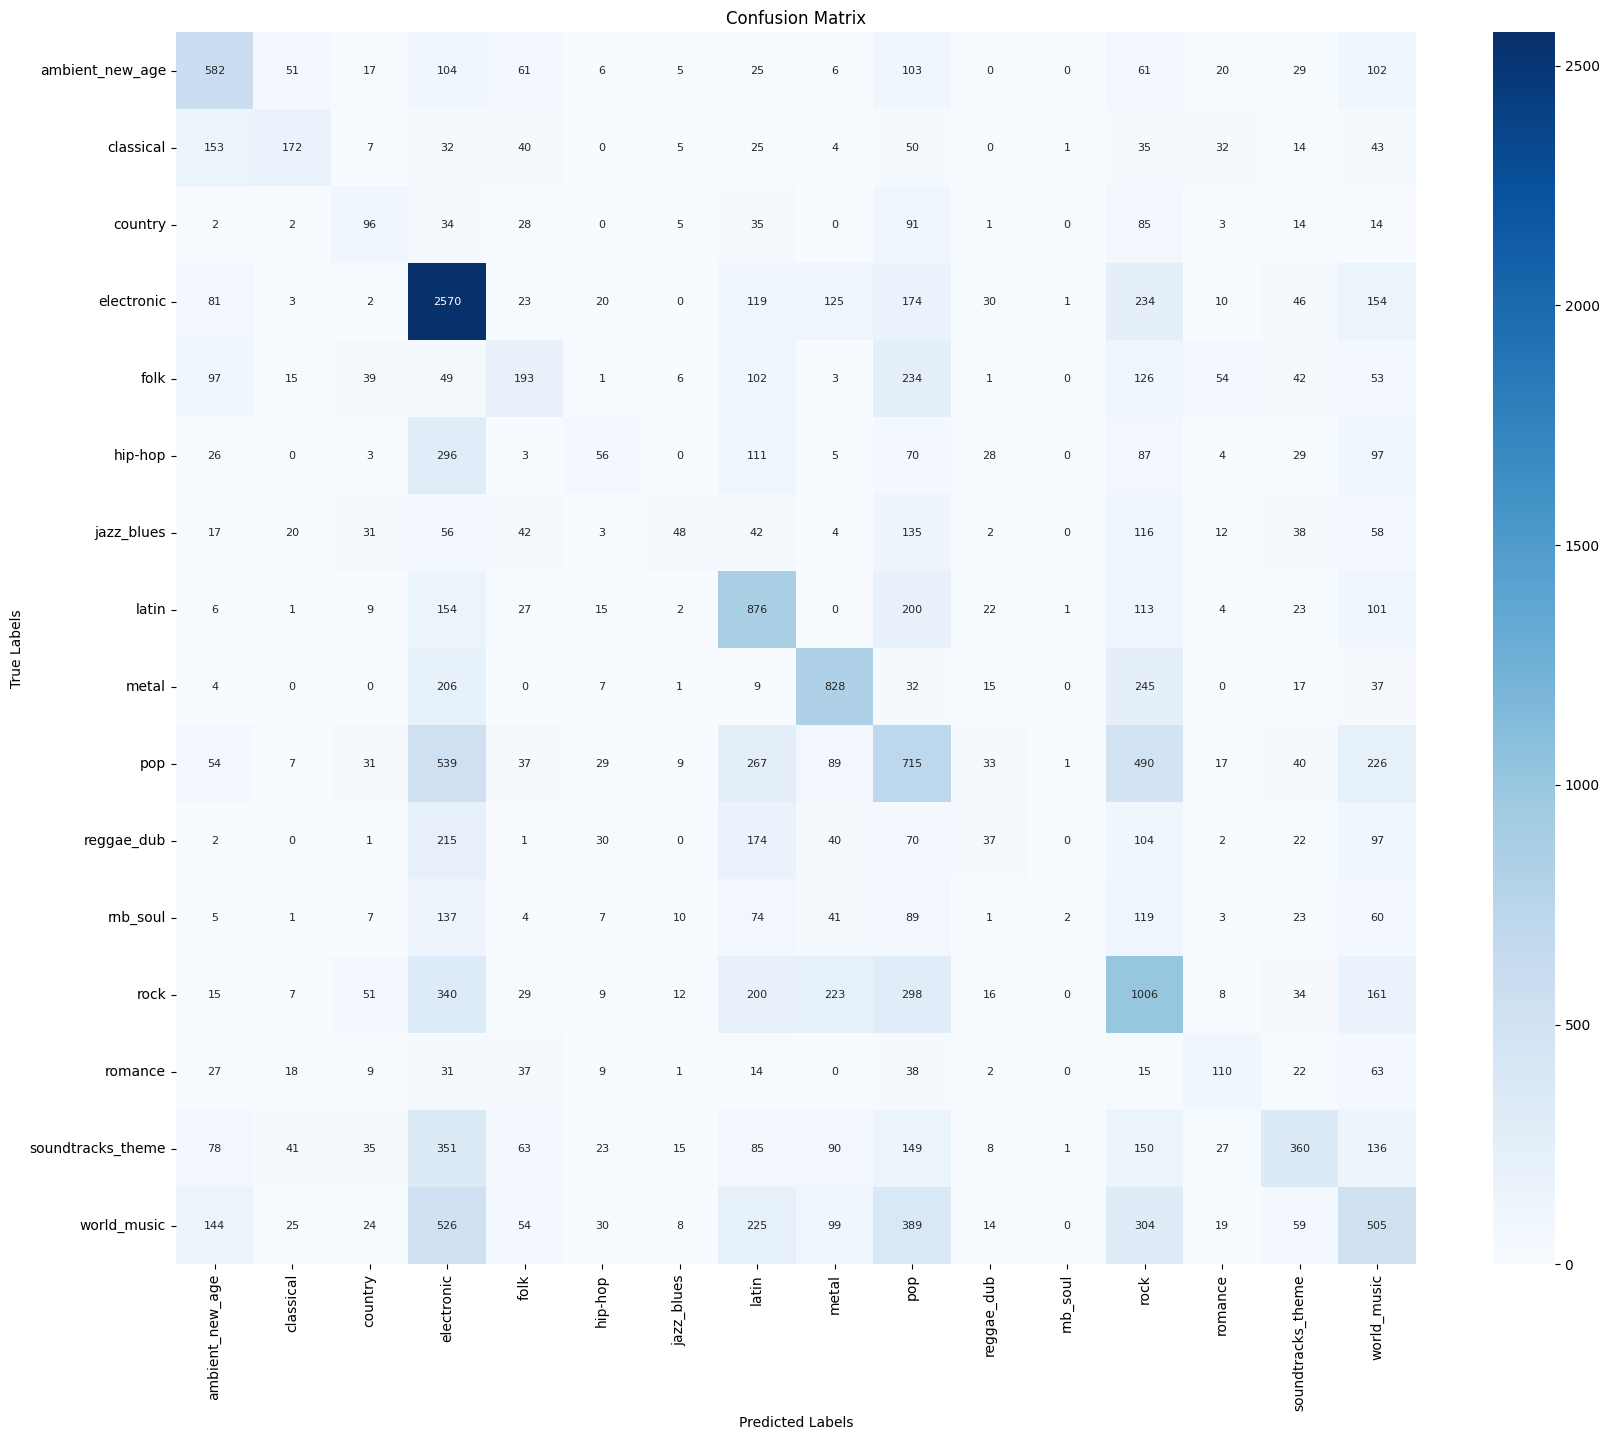

In [35]:
#test the model and check the accuracy for MLP
y_pred_mlp = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()